<a href="https://colab.research.google.com/github/yue-zhongqi/cartpole_colab/blob/main/cartpole.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tutorial and Sample Code for Balancing a Pole on a Cart

## Installing dependencies:

In [ ]:
!apt-get install -y xvfb python-opengl > /dev/null 2>&1
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!pip install gym[classic_control]
!apt-get update > /dev/null 2>&1
!apt-get install cmake > /dev/null 2>&1
!pip install --upgrade setuptools 2>&1
!pip install ez_setup > /dev/null 2>&1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 59.2 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 21.5 MB/s eta 0:00:00
  Attempting uninstall: setuptools
    Found existing installation: setuptools 63.4.3
    Uninstalling setuptools-63.4.3:
      Successfully uninstalled setuptools-63.4.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython 7.9.0 requires jedi>=0.10, which is not installed.
cvxpy 1.2.3 requires setuptools<=64.0.2, but you have setuptools 67.6.0 which is incompatible.


## Importing dependencies and define helper functions

In [ ]:
import gym
from gym import logger as gymlogger
from gym.wrappers import RecordVideo
gymlogger.set_level(40) #error only
import tensorflow as tf
import numpy as np
import random
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import math
import glob
import io
import base64
from IPython.display import HTML
from IPython import display as ipythondisplay

def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else: 
    print("Could not find video")

## Tutorial: Loading CartPole environment

In [ ]:
env = gym.make("CartPole-v1")


We can check the action and observation space of this environment. Discrete(2) means that there are two valid discrete actions: 0 & 1.

In [ ]:
print(env.action_space)

Discrete(2)


The observation space is given below. The first two arrays define the min and max values of the 4 observed values, corresponding to cart position, velocity and pole angle, angular velocity.

In [ ]:
print(env.observation_space)

Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)


We call each round of the pole-balancing game an "episode". At the start of each episode, make sure the environment is reset, which chooses a random initial state, e.g., pole slightly tilted to the right. This initialization can be achieved by the code below, which returns the observation of the initial state.

In [ ]:
observation = env.reset()
print("Initial observations:", observation)

Initial observations: [ 0.0121098  -0.02680078  0.03951741 -0.00675781]


For the CartPole environment, there are two possible actions: 0 for pushing to the left and 1 for pushing to the right. For example, we can push the cart to the left using code below, which returns the new observation, the current reward, an indicator of whether the game ends, and some additional information (not used in this project). For CartPole, the game ends when the pole is significantly tilted or you manage to balance the pole for 500 steps. You get exactly 1 reward for each step before the game ends (i.e., max cumulative reward is 500).

In [ ]:
observation, reward, done, info = env.step(0)
print("New observations after choosing action 0:", observation)
print("Reward for this step:", reward)
print("Is this round done?", done)

New observations after choosing action 0: [ 0.01157379 -0.22246653  0.03938226  0.2981268 ]
Reward for this step: 1.0
Is this round done? False


Now we can play a full round of the game using a naive strategy (always choosing action 0), and show the cumulative reward in the round. Note that reward returned by env.step(*) corresponds to the reward for current step. So we have to accumulate the reward for each step. Clearly, the naive strategy performs poorly by surviving only a dozen of steps.

In [ ]:
observation = env.reset()
cumulative_reward = 0
done = False
while not done:
    observation, reward, done, info = env.step(0)
    cumulative_reward += reward
print("Cumulative reward for this round:", cumulative_reward)

Cumulative reward for this round: 10.0


## Task 1: Development of an RL agent

An example of a naive agent is given below, which randomly chooses an action regardless of the observation:

For Task 1, we can show the observation and chosen action below:

Step 1: Define a set of discrete states for the cart pole's position, velocity, pole andle and pole angluar velocity

In [ ]:
def get_discrete_state(state):
    discrete_state = state/np_array_win_size+ np.array([15,10,1,10])
    return tuple(discrete_state.astype(int))

Step 2: Define the q_policy agent.
This agent relies on epsilon-greedy strategy, which means that 
1. The agent has a higher likelihood of making a random move in its environment in the first few episodes where the value of epsilon is still high
2. Once sufficient training episodes has occured, the value of epsilon will be much lower. It will then have a higher likelihood of making its decision based on its q_table values

In [ ]:
def q_policy_agent(q_table,discrete_state,env,epsilon):
  if np.random.random() > epsilon:
    return np.argmax(q_table[discrete_state]) 
  else:
    return np.random.randint(0, env.action_space.n)


Step 3: Train the model with a sample of 100k episodes:
1. Initialise epsilon to 1, discount factor(gamma) to 0.95, learning rate to 0.1 and the epsilonn decay value to 0.99995
2. If episode is not terminated (done), apply the Q_learning equation:

 **new_q_value = (1 - learning_rate) * old_q_value + learing_rate* (reward + discount * max_q)**
3. The learning rate and epsilon is decayed when the number of training episodes exceed 10000 and when the new rewards outweigh the previous rewards


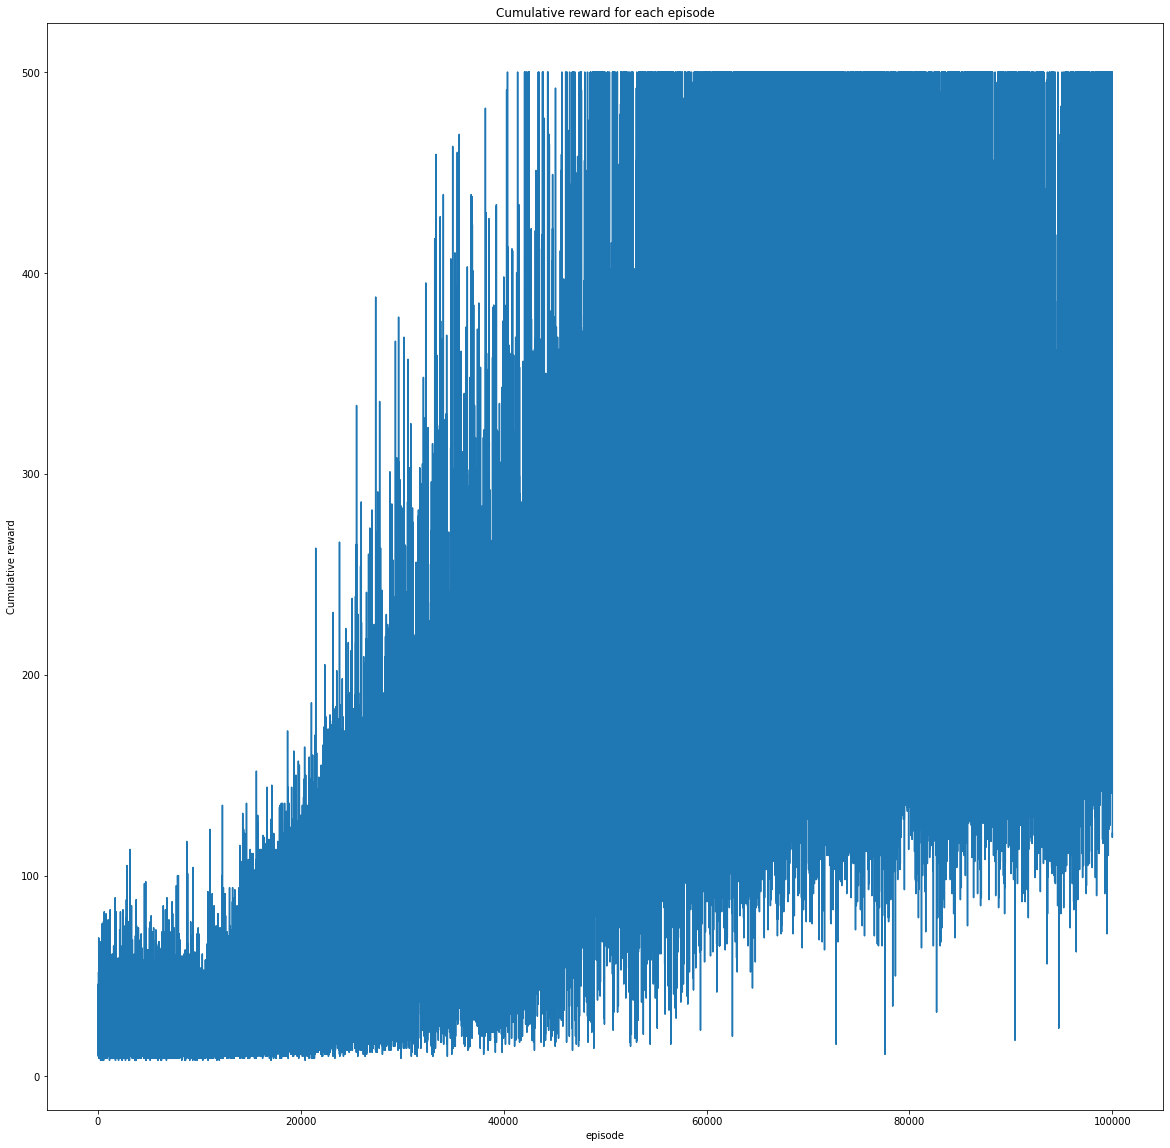

In [ ]:
lr = 0.9
discount = 0.95
observation = [30, 30, 50, 50]
np_array_win_size = np.array([0.25, 0.25, 0.01, 0.1])
prior_reward=0
epsilon = 1
epsilon_decay_value = 0.99995
lr_decay_value = 0.99995
q_table = np.random.uniform(low=0, high=1, size=(observation + [env.action_space.n]))
q_table.shape
training_episode_results = np.zeros((100000,), dtype=int)
training_episode_rewards = 0
for episode in range(len(training_episode_results)): 
  discrete_state = get_discrete_state(env.reset()) 
  done = False
  training_episode_rewards=0
  while not done: 
    action = q_policy_agent(q_table,discrete_state,env,epsilon)
   
    new_state, reward, done, info = env.step(action) 
    training_episode_rewards+=reward

    new_discrete_state = get_discrete_state(new_state)

    if not done: 
        max_future_q = np.max(q_table[new_discrete_state])

        current_q = q_table[discrete_state + (action,)]

        new_q = (1 - lr) * current_q + lr* (reward + discount * max_future_q)

        q_table[discrete_state + (action,)] = new_q
    discrete_state = new_discrete_state
  if epsilon > 0.05: 
    if training_episode_rewards > prior_reward and episode > 10000:
        epsilon = math.pow(epsilon_decay_value, episode - 10000)
        lr = math.pow(lr_decay_value, episode - 10000)
  training_episode_results[episode] = training_episode_rewards
  prior_reward = training_episode_rewards

            
plt.figure(figsize=(20,20))
plt.plot(training_episode_results)
plt.title('Cumulative reward for each episode')
plt.ylabel('Cumulative reward')
plt.xlabel('episode')
plt.show()



For Task 1, we can show the observation and chosen action below:

In [ ]:
discrete_state = get_discrete_state(env.reset()) 
action = np.argmax(q_table[discrete_state])
print("Observation:", observation)
print("Chosen action:", action)

Observation: [30, 30, 50, 50]
Chosen action: 1


## Task 2: Demonstrate the effectiveness of the RL agent

For this task, the agent developed in Task 1 plays the game for 100 episodes, the cumulative results were reorded.

Step 1: Print the average reward over the 100 test episodes. The same logic from training is applied here

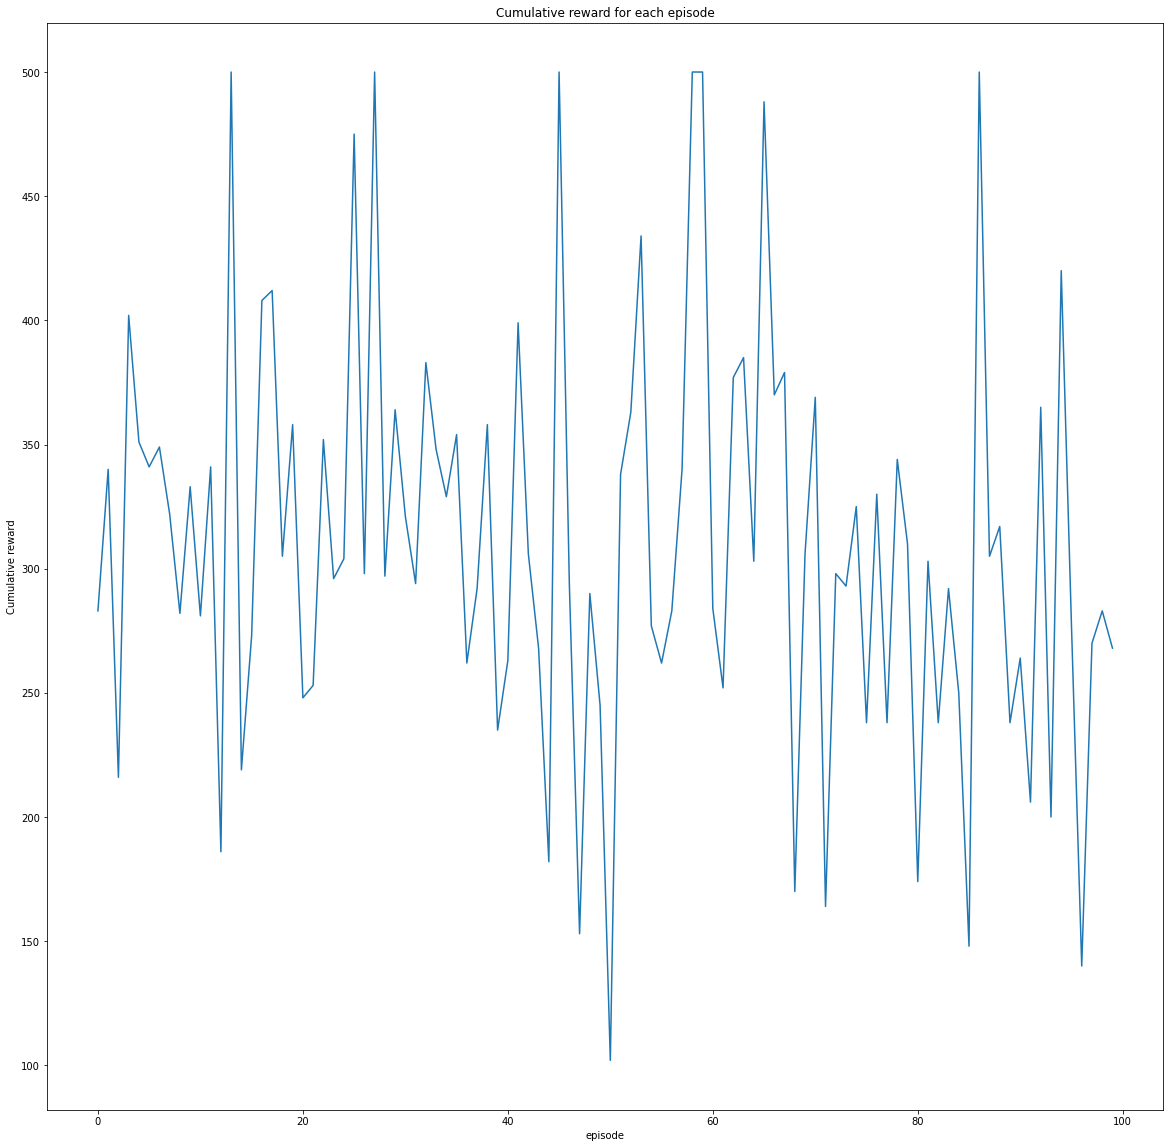

In [ ]:
prior_reward=0
episode_results = np.zeros((100,), dtype=int)
episode_rewards = 0
for episode in range(len(episode_results)): 
  discrete_state = get_discrete_state(env.reset()) 
  done = False
  episode_rewards=0
  while not done: 

    action = q_policy_agent(q_table,discrete_state,env,epsilon)

    new_state, reward, done, info = env.step(action) 
    episode_rewards+=reward

    new_discrete_state = get_discrete_state(new_state)

    if not done: 
        max_future_q = np.max(q_table[new_discrete_state])

        current_q = q_table[discrete_state + (action,)]

        new_q = (1 - lr) * current_q + lr* (reward + discount * max_future_q)

        q_table[discrete_state + (action,)] = new_q
    discrete_state = new_discrete_state
  if epsilon > 0.05: 
    if episode_rewards > prior_reward and episode > 10000:
      epsilon = math.pow(epsilon_decay_value, episode - 10000)
      lr = math.pow(lr_decay_value, episode - 10000)
  episode_results[episode] = episode_rewards
  prior_reward = episode_rewards

            
plt.figure(figsize=(20,20))
plt.plot(episode_results)
plt.title('Cumulative reward for each episode')
plt.ylabel('Cumulative reward')
plt.xlabel('episode')
plt.show()

Step 2: The accuracy of the trained model is measured

In [ ]:
print("Average cumulative reward:", episode_results.mean())
print("Is my agent good enough?", episode_results.mean() > 195)

Average cumulative reward: 310.45
Is my agent good enough? True


## Task 3: Render one episode played by the agent

An episode of the trained model is played

In [ ]:
env = RecordVideo(gym.make("CartPole-v1"), "./video",)
observation = env.reset()
while True:
  env.render()
  discrete_state = get_discrete_state(observation) 
  action = q_policy_agent(q_table,discrete_state,env,epsilon)
  observation, reward, done, info = env.step(action) 
  if done: 
    break;
env.close()
show_video()